In [2]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib  inline

In [25]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [26]:
len(words)

32033

In [27]:
# build the vocab of the characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [28]:
# build the dataset 
block_size = 3
X, Y = [], []
for w in words[:5]:

    print(w)
    context = [0] * block_size
    for ch in w + '.':
        
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [29]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [30]:
# split the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [32]:
C = torch.randn((27,2))  # bcoz 27 possible outcomes and we will have 2 dim embedding

In [33]:
C[5]

tensor([-1.2000,  0.0070])

In [36]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.2000,  0.0070])

In [38]:
 C[torch.tensor([5,6,7,7])]

tensor([[-1.2000,  0.0070],
        [-1.6243, -0.2480],
        [ 0.4384,  1.8706],
        [ 0.4384,  1.8706]])

In [40]:
C[X].shape

torch.Size([32, 3, 2])

In [41]:
X[13,2]

tensor(1)

In [42]:
C[X][13,2]

tensor([-0.8426, -0.9374])

In [43]:
C[1]

tensor([-0.8426, -0.9374])

In [44]:
# embed
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [45]:
# weights and biases
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [46]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [51]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)   # [32,100]

In [52]:
# the final layer
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [53]:
logits = h @ W2 + b2

In [55]:
logits.shape

torch.Size([32, 27])

In [56]:
counts = logits.exp()

In [57]:
probs = counts / counts.sum(1, keepdims=True)

In [58]:
probs.shape

torch.Size([32, 27])

In [61]:
probs[0].sum()

tensor(1.0000)

In [59]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [65]:
probs[torch.arange(32), Y]

tensor([3.8229e-07, 2.8690e-07, 6.0119e-07, 1.6899e-09, 1.0411e-12, 1.7022e-05,
        1.5937e-09, 6.0013e-10, 9.9708e-07, 9.4719e-08, 1.3957e-10, 1.1933e-18,
        1.6050e-10, 5.0698e-05, 3.5638e-10, 7.5430e-13, 4.0972e-05, 2.0498e-15,
        2.9215e-03, 3.1676e-09, 4.6782e-13, 1.6893e-06, 3.6888e-12, 8.9116e-09,
        4.2268e-14, 2.7279e-09, 1.1020e-14, 4.7270e-05, 5.0029e-06, 1.0810e-05,
        2.9525e-11, 9.9300e-15])

In [62]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [68]:
# negative log likelihood
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(20.2846)

In [69]:
#----------------- now made respectable ----------------

In [70]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [121]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [122]:
sum(p.nelement() for p in parameters)  # no of parameters in total

3481

In [123]:
for p in parameters:
    p.requires_grad = True

In [124]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [125]:
lri = []
lossi = []
for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]                                  
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)    
    logits = h @ W2 + b2                        
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss =F.cross_entropy(logits, Ytr[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lr)
    lossi.append(loss.item())

# print(loss.item())

17.49295997619629
17.53890037536621
16.711923599243164
17.909435272216797
16.010486602783203
19.582313537597656
20.99517059326172
21.008560180664062
18.25009536743164
16.614412307739258
20.685409545898438
14.462725639343262
20.7459716796875
15.714792251586914
16.00421142578125
18.7075138092041
14.056500434875488
18.459476470947266
19.253780364990234
17.01628303527832
15.677833557128906
17.372905731201172
18.306459426879883
16.666202545166016
14.797929763793945
15.199975967407227
15.52534008026123
18.400718688964844
18.58263397216797
15.282691955566406
14.564085006713867
16.192344665527344
19.24593734741211
16.26400375366211
17.759746551513672
15.716645240783691
19.91823387145996
17.649837493896484
17.980112075805664
15.71250057220459
16.267257690429688
19.710519790649414
16.117713928222656
13.348204612731934
14.970056533813477
13.11141300201416
16.445829391479492
18.203264236450195
17.32341194152832
14.462244987487793
18.872089385986328
13.811039924621582
15.422805786132812
19.65917968

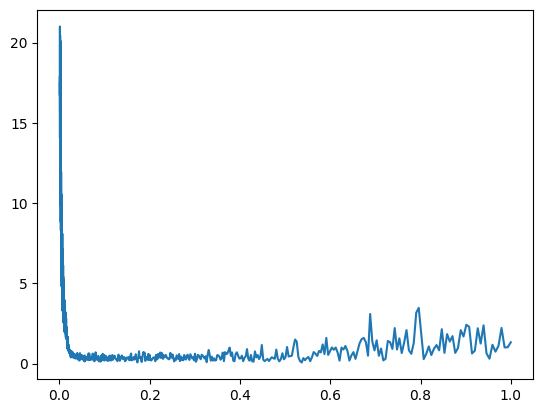

In [126]:
plt.plot(lri, lossi)

In [90]:
logits = torch.tensor([-2, -3, 0, 5])  
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

In [102]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3349, 17.7903, 20.6014, 20.6123, 16.7355, 13.3349, 15.9982, 14.1721,
        15.9144, 18.3614, 15.9394, 20.9265, 13.3349, 17.1091, 17.1320, 20.0602,
        13.3349, 16.5894, 15.1017, 17.0582, 18.5859, 15.9669, 10.8740, 10.6870,
        15.5056, 13.3349, 16.1795, 16.9742, 12.7426, 16.2010, 19.0844, 16.0197],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [104]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])